# Clustering and Visualization of Phoebe dataset

## Components
* Create dataset with every row linked to the image it was generated from
    * Will need to extract images from videos like this:
    `ffmpeg -ss 00:23:00 -i video.mp4 -frames:v 1 out_time.jpg`


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from importlib import reload  # Not needed in Python 2
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

import os
DATASET_FILE = "Phoebe_dataset4.zip"
full_path = os.path.abspath(DATASET_FILE[:-4])
if not os.path.exists(full_path):
    !unzip -o $DATASET_FILE;

<module 'logging' from '/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.7/lib/python3.7/logging/__init__.py'>

---
## Load datasets
### Helper functions

In [3]:
# import os, os.path
from typing import List, Dict, Union, Any
import csv
import uuid
import re
import time
import datetime
import logging

# Paths
PATH_DATASET = "Phoebe_dataset4"
PATH_AU_INTENSITY = "single_person_au_intensity"
PATH_AU_PRESENCE = "single_person_au_presence"
PATH_TRAIN = "train"
PATH_TEST = "test"
PATH_TRAINING_VIDEOS = PATH_DATASET + "/videos/train"
PATH_PROCESSED_IMAGES = PATH_DATASET + "/processed_images"
PATH_TRAINING_CSV = f"./{PATH_DATASET}/{PATH_AU_INTENSITY}/{PATH_TRAIN}/"

# General
EXT_MP4 = "mp4"

# Stores
IMAGE_STORE = {}

log = logging.getLogger()
log.setLevel(logging.DEBUG)

if not os.path.isdir(PATH_PROCESSED_IMAGES):
    os.mkdir(PATH_PROCESSED_IMAGES)

In [4]:
def load_dataset(filename: str) -> List[Union[str, float]]:
    """Load dataset for a single csv/video pair.
    
    :param filename: name of video and csv without an extension.
    
    :return: result dataset for csv/video pair.
    """
    # Load csv with python library so that first column may be removed.
    print(filename)
    raw_data = []
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        
        for index, row in enumerate(reader):
            if index == 0:
                row = [x.strip() for x in row]
                # Rename column row
                row[0] = "frame"
                
                # Create a new column to save filename the row came from.
                # This is used to extract image when needed (filename + frame are needed)
                row.insert(0, "filename")
                
            elif row[0] != "":
                # Create an image for every row and add to dictionnary {id: path}
                filename_without_ext: str = re.findall(r"[0-9]+", filename)[-1]
                row.insert(0, filename_without_ext)
            raw_data.append(row)
    
    return raw_data

def create_full_dataset(training_files) -> List[Union[str, float]]:
    """Load dataset for every csv/video pair.
    
    :param training_files: list of csv files.
    
    :return: full dataset results
    """
    assert(isinstance(training_files, list)) 
    full_dataset = []
    for file in training_files:
        dataset = load_dataset(file)
        if len(full_dataset) == 0:
            full_dataset = dataset
        else:
            full_dataset.extend(dataset[1:])
    return full_dataset

### Get image
If image has not been extracted for given id, extract it from corresponding video. This is made easy because the matrix stores the video name (without the extension) and the frame number.

Pass the entire row of data to the `extract_image_for_frame` function in order to get the correct frame.

In [5]:
from IPython.display import display, Image
import datetime

# %%capture
def extract_image_for_frame(image_path: str, video_name: str, frame: str):
    """Extracts a frame from a video given a timestamp in seconds.
    
    :param orig_filename: name of video for which timestamp applies
    :param row_id: id of row and image
    
    :return: name of the image without its extension.
    """

    video_filepath = PATH_TRAINING_VIDEOS + f"/{video_name}.{EXT_MP4}"
    
    # Data was sampled at about 30fps. Get time at which it is in the video
    time_in_seconds = (1/30) * frame
    time_datetime = datetime.timedelta(seconds=time_in_seconds)
    
    # log.debug(f"Extracting frame at time {time_datetime} from path {video_filepath}")        
    # command = f"ffmpeg -i {video_filepath} -r 30 {image_path}.jpg"
    
    # Find frame closest to time. Sometimes if '-noaccurate_seek' not specified
    command = f"ffmpeg -ss {time_datetime}  -noaccurate_seek -i {video_filepath} -vframes 1 {image_path} -n"
    print(f"Running command: {command}")

    print(f"### ")
    !$command;

def image_path_for_row(row: List[Any]):
    """Return path of image for a row"""
    video_name = int(row[0])
    frame = int(row[0])
    image_name = f"{video_name:03}{frame:03}"
    image_path = PATH_PROCESSED_IMAGES + "/" + image_name + ".jpeg"
    if not os.path.exists(image_path):
        extract_image_for_frame(image_path, video_name, frame)
    return image_path
    
def show_image_from_row(row: List[Any]):
    """
    :param row: a row of data from full_dataset (a python list which contains the header). This
        is a bit ugly, but it is the way I started it.
    :param show: whether to directly print the image
    
    TODO: perhaps revise calling interface.
    """
    # log.debug(f"### Getting image for row: {row}")
    
    image_path = image_path_for_row(row)
    
    try:
        image = Image(filename=f'{image_path}.jpg')
        display(image)
    except IOError as e:
        print(e)      

### Run dataset preparation pipeline

In [6]:
# %%capture
training_files: List[str] = [f"{PATH_TRAINING_CSV}{name}" for 
                             name in os.listdir(f"{PATH_TRAINING_CSV}") if 
                             name[-4:] == ".csv"]

print(training_files[0:2])
# Load datasets
full_dataset = create_full_dataset(training_files)

['./Phoebe_dataset4/single_person_au_intensity/train/6.csv', './Phoebe_dataset4/single_person_au_intensity/train/40.csv']
./Phoebe_dataset4/single_person_au_intensity/train/6.csv
./Phoebe_dataset4/single_person_au_intensity/train/40.csv
./Phoebe_dataset4/single_person_au_intensity/train/41.csv
./Phoebe_dataset4/single_person_au_intensity/train/7.csv
./Phoebe_dataset4/single_person_au_intensity/train/43.csv
./Phoebe_dataset4/single_person_au_intensity/train/5.csv
./Phoebe_dataset4/single_person_au_intensity/train/4.csv
./Phoebe_dataset4/single_person_au_intensity/train/42.csv
./Phoebe_dataset4/single_person_au_intensity/train/46.csv
./Phoebe_dataset4/single_person_au_intensity/train/1.csv
./Phoebe_dataset4/single_person_au_intensity/train/47.csv
./Phoebe_dataset4/single_person_au_intensity/train/3.csv
./Phoebe_dataset4/single_person_au_intensity/train/45.csv
./Phoebe_dataset4/single_person_au_intensity/train/44.csv
./Phoebe_dataset4/single_person_au_intensity/train/50.csv
./Phoebe_datas

In [7]:
print(len(full_dataset))
print(full_dataset[0:5])

3217
[['filename', 'frame', 'face_id', 'confidence', 'success', 'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r'], ['6', '0', '0', '0.98', '1', '0.11', '0.0', '0.0', '0.0', '1.33', '2.09', '0.0', '1.1', '1.62', '0.08', '0.1', '0.15', '0.0', '0.0', '0.0', '0.29', '0.0'], ['6', '1', '0', '0.98', '1', '0.04', '0.0', '0.13', '0.08', '1.42', '2.2', '0.13', '1.14', '1.61', '0.03', '0.14', '0.4', '0.0', '0.0', '0.12', '0.1', '0.01'], ['6', '2', '0', '0.98', '1', '0.0', '0.0', '0.13', '0.08', '1.43', '2.08', '0.13', '1.02', '1.53', '0.02', '0.1', '0.35', '0.17', '0.0', '0.23', '0.14', '0.13'], ['6', '3', '0', '0.98', '1', '0.0', '0.0', '0.08', '0.15', '1.43', '1.84', '0.07', '0.86', '1.36', '0.06', '0.01', '0.12', '0.17', '0.08', '0.18', '0.28', '0.3']]


In [8]:
# Images in Image datastore are "fileid_frame"
show_image_from_row(full_dataset[1])

[Errno 2] No such file or directory: 'Phoebe_dataset4/processed_images/006006.jpeg.jpg'


In [9]:
count = 3
print(f"First {count} rows of dataset:\n")
for i in range(0, count):
    print(str(full_dataset[i]) + "\n")

First 3 rows of dataset:

['filename', 'frame', 'face_id', 'confidence', 'success', 'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r']

['6', '0', '0', '0.98', '1', '0.11', '0.0', '0.0', '0.0', '1.33', '2.09', '0.0', '1.1', '1.62', '0.08', '0.1', '0.15', '0.0', '0.0', '0.0', '0.29', '0.0']

['6', '1', '0', '0.98', '1', '0.04', '0.0', '0.13', '0.08', '1.42', '2.2', '0.13', '1.14', '1.61', '0.03', '0.14', '0.4', '0.0', '0.0', '0.12', '0.1', '0.01']



---
## Preprocess and cleanup data
- [X] Remove rows with confidence < 85
- [X] Remove rows with empty value(s)

### Compare ML algorithms for
- [ ] Scaled AU between 0 and 1, and unscaled AUs

In [10]:
from pprint import pprint

CONFIDENCE_LEVEL = 0.85

full_dataset_header = full_dataset[0]
keys_full_dataset = {j: i for i, j in enumerate(full_dataset_header)}
index_to_key = {i: j for i, j in enumerate(full_dataset_header)}

print(f"keys_full_dataset:")
pprint(keys_full_dataset)

print(f"type(full_dataset): \t{type(full_dataset)}")      

# NOTE: because full_dataset stores strings in the first row, it must be skipped
# in list comprehensions. Furthermore, the strings also need to be cast to whatever
# format they are being compared to (int, float).

# Only keep rows that have "success = 1"
full_dataset_all_success = [x for x in full_dataset[1:] 
                            if int(x[keys_full_dataset["success"]]) == 1]
log.debug("Removed {} rows with 'success = 0'".format(
    len(full_dataset) - len(full_dataset_all_success)))

# Only keep rows that have "confidence > 0.85"
full_dataset_good_confidence = [x for x in full_dataset_all_success[1:] 
                                if float(x[keys_full_dataset["confidence"]]) >= CONFIDENCE_LEVEL]
log.debug("Removed {} rows with 'confidence < 0'".format(
    len(full_dataset_all_success) - len(full_dataset_good_confidence)))

# Do not edit final_dataset. It is there to keep indempotency in case more filters
# need to be added above. The final dataset has all unwanted rows removed, but still
# has the header row.
final_dataset = full_dataset_good_confidence

09:25:04 DEBUG:Removed 86 rows with 'success = 0'
09:25:04 DEBUG:Removed 43 rows with 'confidence < 0'


keys_full_dataset:
{'AU01_r': 5,
 'AU02_r': 6,
 'AU04_r': 7,
 'AU05_r': 8,
 'AU06_r': 9,
 'AU07_r': 10,
 'AU09_r': 11,
 'AU10_r': 12,
 'AU12_r': 13,
 'AU14_r': 14,
 'AU15_r': 15,
 'AU17_r': 16,
 'AU20_r': 17,
 'AU23_r': 18,
 'AU25_r': 19,
 'AU26_r': 20,
 'AU45_r': 21,
 'confidence': 3,
 'face_id': 2,
 'filename': 0,
 'frame': 1,
 'success': 4}
type(full_dataset): 	<class 'list'>


### Show image from index

In [11]:
def image_path_from_index(index: int):
    # full_dataset/final_dataset has +1 row than numpy array index was pulled from
    path = image_path_for_row(final_dataset[index + 1])
    return path

### Train first GMM

In [12]:
from sklearn import preprocessing
import numpy as np

only_AU_info = [x[keys_full_dataset["AU01_r"]:] 
                for x in final_dataset[1:]]

X_train = np.array(only_AU_info, dtype=float)

# # Scale AUs
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_train = min_max_scaler.fit_transform(X_train)
    
print(f"X_train.shape: \t\t{X_train.shape}\n")
# Just make sure only the 17 AU are there
assert(X_train.shape[1] == 17)

count = 3
print(f"First {count} rows of X_train:")
for i in range(0, count):
    print(str(X_train[i]) + "\n")

X_train.shape: 		(3087, 17)

First 3 rows of X_train:
[0.         0.         0.03693182 0.04761905 0.42058824 0.492891
 0.07926829 0.3100304  0.478125   0.00566572 0.02061856 0.07070707
 0.11971831 0.         0.06571429 0.035      0.05963303]

[0.         0.         0.02272727 0.08928571 0.42058824 0.43601896
 0.04268293 0.26139818 0.425      0.01699717 0.00206186 0.02424242
 0.11971831 0.01965602 0.05142857 0.07       0.13761468]

[0.         0.01777778 0.01704545 0.04166667 0.39705882 0.41943128
 0.04878049 0.24012158 0.421875   0.05382436 0.         0.00808081
 0.11971831 0.02702703 0.12285714 0.1125     0.16513761]



---
## Gausian Mixture Model

In [13]:
def make_ellipses(gmm, ax):
    for n, color in enumerate('rgb'):
        v, w = np.linalg.eigh(gmm._get_covars()[n][:2, :2])
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v *= 9
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

09:25:04 DEBUG:CONFIGDIR=/Users/leo/.matplotlib
09:25:04 DEBUG:(private) matplotlib data path: /Users/leo/workspace/cmpt419/CMPT419-A2/venv/lib/python3.7/site-packages/matplotlib/mpl-data
09:25:04 DEBUG:matplotlib data path: /Users/leo/workspace/cmpt419/CMPT419-A2/venv/lib/python3.7/site-packages/matplotlib/mpl-data
09:25:04 DEBUG:loaded rc file /Users/leo/workspace/cmpt419/CMPT419-A2/venv/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc
09:25:04 DEBUG:matplotlib version 3.2.1
09:25:04 DEBUG:interactive is False
09:25:04 DEBUG:platform is darwin
09:25:04 DEBUG:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.cp437', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', 'posixpath', 'genericpath', 'os.pat

First 3 trained rows of probabilities table: 
[[0.007 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.993]
 [1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.   ]]
Max probability value of any category for 100 row: 
[0.993152   0.9999909  1.         0.99999992 0.99999757 0.84693589
 0.93146266 0.99769418 0.9952789  0.98640165 0.98829224 0.99016987
 0.99996049 0.99999875 0.6261722  0.88638008 0.93280772 0.98939417
 0.99090889 0.98715626 0.95373238 0.99989467 0.92549501 0.99621792
 0.9998857  0.99999151 0.99999863 0.91880099 0.99999802 0.99999774
 0.99995663 1.         0.82342397 1.         0.99999999 0.75423569
 0.52921371 0.87608785 0.99337161 0.99999924 0.99999556 1.
 1.         0.99975531 0.99994324 0.99999689 0.99999954 1.
 1.         1.         1.         1.         1.         1.
 0.7624101

09:25:06 DEBUG:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05
09:25:06 DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal 700 normal>) = 10.335
09:25:06 DEBUG:findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal light normal>) = 10.24
09:25:06 DEBUG:findfont: score(<Font '.SF NS Mono' (SFNSMono.ttf) normal normal light normal>) = 10.24
09:25:06 DEBUG:findfont: score(<Font 'Iosevka Slab' (iosevka-slab-lightitalic.ttc) italic normal light normal>) = 11.24
09:25:06 DEBUG:findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-Regular.ttf) normal normal regular normal>) = 10.05
09:25:06 DEBUG:findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal regular normal>) = 10.05
09:25:06 DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneral.otf) normal normal regular normal>) = 10.05
09:25:06 DEBUG:findfont: score(<Font 'Noto Sans Glagolitic' (NotoSansGlagolitic-Regular.ttf) normal normal regular normal>) = 1

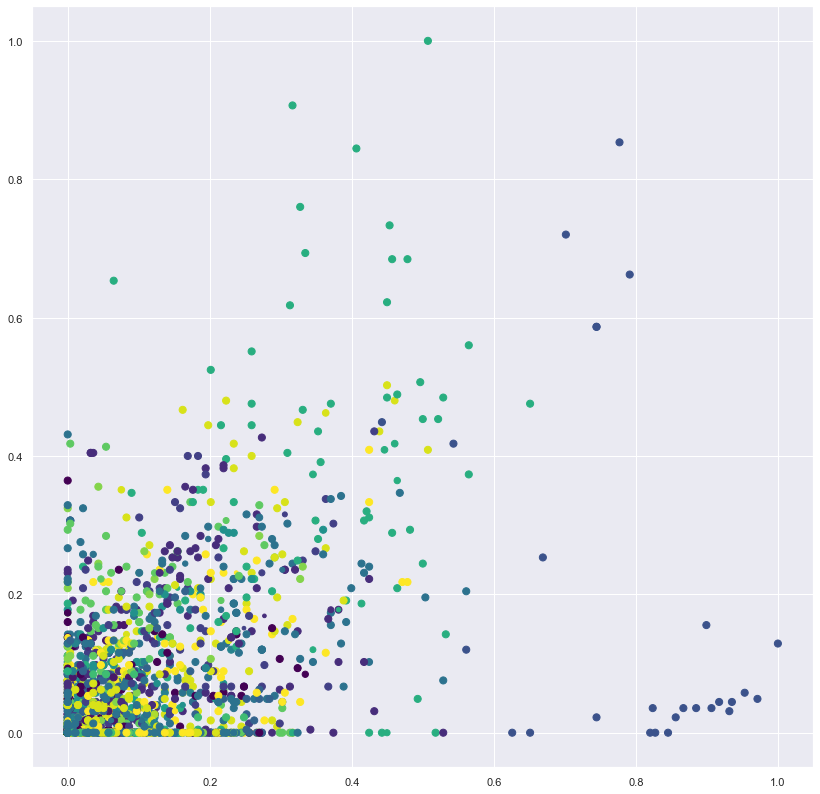

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

from sklearn.mixture import GaussianMixture as GMM


X_train_with_labels = X_train

gmm = GMM(n_components=17).fit(X_train)
probs = gmm.predict_proba(X_train) 
count = 3
print(f"First {count} trained rows of probabilities table: \n{probs[:count].round(3)}")

# Print maximum probability for every row. The closest it is to 1, the more
# certain GMM is about that point (=row).
count = 100
maxInRows = np.amax(probs, axis=1)
print(f"Max probability value of any category for {count} row: \n{maxInRows[:count]}")


labels = gmm.predict(X_train)
size = 50 * probs.max(1) ** 2 # square emphasizes differences
plt.figure(figsize=(14,14))
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels, s=size, cmap='viridis');

The current GMM does not show any clear blobs. Rather, the data seems to be scattered heterogeneously. However, I can see in the probabilities for individual points that each point has a high probability of belonging to a single cluster. Therefore, I think that the high level of dimensions of the data is problematic.

### Determine optimal number of components

/Users/leo/workspace/cmpt419/CMPT419-A2/venv/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
09:25:21 DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
09:25:21 DEBUG:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
09:25:21 DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
09:25:21 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
09:25:21 DEBUG:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
09:25:21 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
09:25:21 DEBUG:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal norma

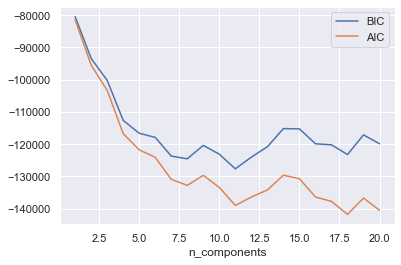

In [15]:
# Turn off DEBUG logs otherwise the below graph fills the logs...
logging.basicConfig(level=logging.ERROR)

n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(X_train)
          for n in n_components]
plt.plot(n_components, [m.bic(X_train) for m in models], label='BIC') 
plt.plot(n_components, [m.aic(X_train) for m in models], label='AIC') 
plt.legend(loc='best')
plt.xlabel('n_components');

The best number of components is about 17. This makes sense since there are 17 parameters in the training data.

### Most representative image per component

09:33:11 DEBUG:Max values for the 17 AU columns: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

09:33:11 DEBUG:Tuple (AU_num, row_num) for max value of every AU column: 
[(0, 1317), (1, 2432), (2, 511), (3, 50), (4, 501), (5, 2199), (6, 1169), (7, 1681), (8, 1988), (9, 1222), (10, 48), (11, 103), (12, 378), (13, 3018), (14, 676), (15, 244), (16, 1184)]



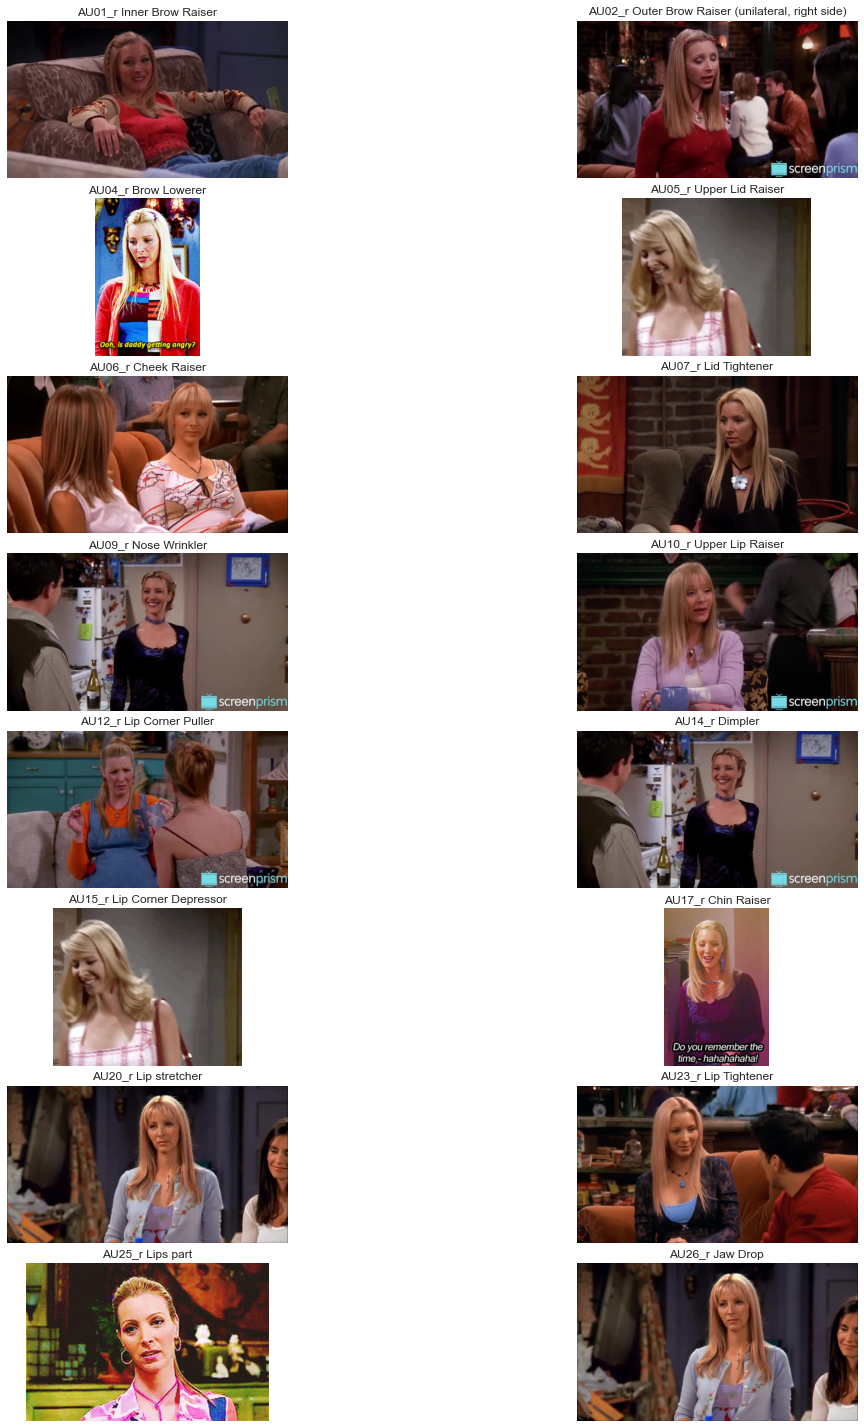

In [27]:
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL

# AU to descriptor dict
AU_DESCRIPTOR = {
    "AU01": "Inner Brow Raiser",
    "AU02": "Outer Brow Raiser (unilateral, right side)",
    "AU04": "Brow Lowerer",
    "AU05": "Upper Lid Raiser",
    "AU06": "Cheek Raiser",
    "AU07": "Lid Tightener",
    "AU09": "Nose Wrinkler",
    "AU10": "Upper Lip Raiser",
    "AU12": "Lip Corner Puller",
    "AU14": "Dimpler",
    "AU15": "Lip Corner Depressor",
    "AU17": "Chin Raiser",
    "AU20": "Lip stretcher",
    "AU23": "Lip Tightener",
    "AU25": "Lips part",
    "AU26": "Jaw Drop",
    "AU45": "Blink",
}

# Turn on DEBUG logs otherwise the below graph fills the logs...
logging.basicConfig(level=logging.DEBUG)

def present_data(X_matrix):
    """For each category (aka column), present the row's images and 
    metadata which have the highest probability of being in that category.
    """
    
    # Gaussian probabilities for every row of data
    probs = gmm.predict_proba(X_matrix) 
    
    # Find the row index of the highest value for every column. The row index can be linked back to its image.
    maxval = np.max(probs, axis=0)
    log.debug(f"Max values for the 17 AU columns: {maxval}\n")

    # Transform to panda dataframe to find rows with highest value for each category
    probs_pd = pd.DataFrame(probs)

    # [AU_num, row_num]
    indices: List[Tuple[int]] = []

    for i in range (0, 17):
        indices.append((i, probs_pd[i].argmax()))
    log.debug(f"Tuple (AU_num, row_num) for max value of every AU column: \n{indices}\n")

    # To access key name from dictionary, account for 5 deleted columns that precede AU columns
    ACCOUNT_FOR_5_MISSING_HEADER_COLS = 5
    # Show image for every AU

    def get_row_metadata(row_index: int):
        """Return probabilities for each class"""
        # Get row from probability matrix

        row_X = X_matrix[row_index]
        row_probs = probs[row_index,]
        np.set_printoptions(precision=2)
        np.set_printoptions(suppress=True)
        log.debug(f"ROW_X: \t\t{row_X}")
        log.debug(f"ROW_probs: \t{row_probs}")
        
        # Show all probabilities > 50
        pass

    fig, ax_array = plt.subplots(int(len(indices)/2), 2, figsize=(20,20))
    axes = ax_array.flatten()
    
    for i, ax in enumerate(axes):
        AU_type = index_to_key[indices[i][0] + ACCOUNT_FOR_5_MISSING_HEADER_COLS]
        title = AU_type + " " + AU_DESCRIPTOR[AU_type[:4]]
        img_path = image_path_from_index(indices[i][1])
        ax.set_title(title)
        img=mpimg.imread(img_path)
        ax.imshow(img)
    plt.setp(axes, xticks=[], yticks=[], frame_on=False)
    plt.tight_layout(h_pad=0.5, w_pad=0.01)
    
#     for i in indices:
#         plt.figure()
#         img_path = image_path_from_index(i[1])
#         img=mpimg.imread(img_path)
#         plt.axis('off')
#         plt.grid(b=None)
#         imgplot = plt.imshow(img)

#         AU_type = index_to_key[i[0] + ACCOUNT_FOR_5_MISSING_HEADER_COLS]
#         title = AU_type + " " + AU_DESCRIPTOR[AU_type[:4]]

#         metadata = get_row_metadata(i[1])
#         plt.suptitle(title)
#         plt.title("sthgrf")
#         plt.show()

present_data(X_train)

The images and data rows for AU26 and AU45 show that they have different AU levels despite being almost the same. 
One way to circumvent this issue could be make every AU change less rapidly between time connected points. I guess that I am here talking about doing a temporal normalization on every AU.

## Apply UMAP
Reduce dimensions of the dataset.

In [75]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

09:03:56 DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [ ]:
%%capture
logging.basicConfig(level=logging.ERROR)

import umap

reducer = umap.UMAP()
# embedding = reducer.fit_transform(X_train)
# embedding.shape

09:20:53 DEBUG:bytecode dump:
>          0	NOP(arg=None, lineno=79)
           2	SETUP_LOOP(arg=502, lineno=79)
           6	LOAD_GLOBAL(arg=0, lineno=79)
           8	LOAD_METHOD(arg=1, lineno=79)
          10	LOAD_FAST(arg=5, lineno=79)
          12	LOAD_ATTR(arg=2, lineno=79)
          14	LOAD_CONST(arg=1, lineno=79)
          16	BINARY_SUBSCR(arg=None, lineno=79)
          18	CALL_METHOD(arg=1, lineno=79)
          20	GET_ITER(arg=None, lineno=79)
>         22	FOR_ITER(arg=480, lineno=79)
          26	STORE_FAST(arg=17, lineno=79)
          28	LOAD_FAST(arg=15, lineno=80)
          30	LOAD_FAST(arg=17, lineno=80)
          32	BINARY_SUBSCR(arg=None, lineno=80)
          34	LOAD_FAST(arg=16, lineno=80)
          36	COMPARE_OP(arg=1, lineno=80)
          38	POP_JUMP_IF_FALSE(arg=22, lineno=80)
          40	LOAD_FAST(arg=2, lineno=81)
          42	LOAD_FAST(arg=17, lineno=81)
          44	BINARY_SUBSCR(arg=None, lineno=81)
          46	STORE_FAST(arg=18, lineno=81)
          48	LOAD_F